In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.externals import joblib
%load_ext autoreload
%autoreload 2
#pca yа обоих этапах; bagged pca+boost
#пофитить кружки
#удалить "вылеты по касательной"

In [2]:
raw_train = pd.read_csv('train.csv')
#raw_test = pd.read_csv('test.csv')


In [2]:
def group_by_event(data,n_wires= 4482):
    len_events = data.shape[0]/n_wires
    #ASSUME IT GOES IN A (event_id, wire_id)-lexicographic order
    return data.reshape((len_events,n_wires))

In [3]:
wires = pd.read_csv('wires.csv')
wires['_x']= wires.wire_rho*np.cos(wires.wire_phi)
wires['_y']= wires.wire_rho*np.sin(wires.wire_phi)
def draw_wire(data_row,cmap='Greys'):
    plt.figure(figsize=[12,10])
    
    pts = plt.scatter(wires._x,wires._y, c= data_row,cmap=cmap)
    
    plt.colorbar(orientation='vertical')
    plt.show()

In [9]:
evt_labels = group_by_event(raw_train.label)
evt_e = group_by_event(raw_train.energy_deposit)
evt_t = group_by_event(raw_train.relative_time)

evt id= 863


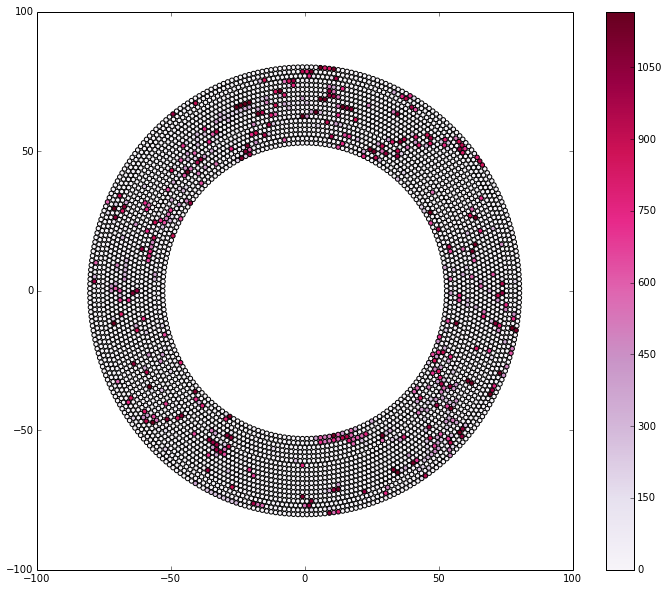

In [6]:
i = np.random.randint(1700)
print 'evt id=',i
draw_wire(evt_t[i,:],cmap='PuRd')
#draw_wire(evt_t[i,:]*(evt_labels[i,:]==1),cmap='Greys')


In [4]:
def to_features(raw_data,test=False):    
    
    data_sb = raw_data[raw_data.energy_deposit>0]
    features = {}
    
    features["timesq"] = np.array(data_sb.relative_time)**2
    features["enrgsqlog"] = np.log(np.array(data_sb.energy_deposit))**2
    features["wrho"] = wires.wire_rho[data_sb.wire_id]
    features["rhotime"] = wires.wire_rho[data_sb.wire_id]/(np.array(data_sb.relative_time)+1.)
    features["relergy"] = np.log(np.array(data_sb.energy_deposit))/(np.array(data_sb.relative_time)+.1)
    features["rhonergy"] = np.log(np.array(data_sb.energy_deposit))/(np.array(data_sb.energy_deposit)+.1)
    #features["wphi"] = wires.wire_phi[data_sb.wire_id]
    
    
    return (pd.DataFrame(features),data_sb.global_id ) if test else (pd.DataFrame(features),data_sb.label==1,data_sb.global_id)



In [6]:

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


In [ ]:
subm = True
read = False
read_pca=True
fname = 'dumps/lastrgb-250'
pname = 'dumps/lastpca'

if subm:
    if not read_pca:
        from sklearn.decomposition import PCA
        Xtest,_ = to_features(pd.read_csv('test.csv'),test=True)
        pca = PCA().fit(Xtest)
        joblib.dump(pca,pname)
        del Xtest,_
    else:
        pca = joblib.load(pname)
    if not read:
        raw_train = pd.read_csv('train.csv')
        Xfeat,Y,Ids = to_features(raw_train)
        Xtrans =Xfeat#pca.transform(Xfeat)

        from sklearn.ensemble import GradientBoostingClassifier
        rf = GradientBoostingClassifier(n_estimators = 250,
                                     learning_rate=0.15,
                                     max_depth=9,
                                     verbose=2)
        #from sklearn.ensemble import RandomForestClassifier
        
        #rf = RandomForestClassifier(n_estimators=250,n_jobs=-1,verbose=2)
        rf.fit(Xtrans,Y)
        joblib.dump(rf,fname)
    else:
        rf = joblib.load(fname)
    raw_test = pd.read_csv('test.csv')
    
    n_parts = 100
    part_size = (len(raw_test)-1)/n_parts +100
    Y_parts = []
    ids_parts = []
    for i in range(n_parts):        
        raw_test_part = raw_test[i*part_size : (i+1)*part_size]
        data_test_part,ids_test_part = to_features(raw_test_part,test=True)
        data_test_trans = data_test_part#pca.transform(data_test_part)
        Y_test_part = rf.predict_proba(data_test_trans)[:,1]

        Y_parts.append(Y_test_part)
        ids_parts.append(ids_test_part)
    Y_test = np.concatenate(Y_parts)
    ids_test = np.concatenate(ids_parts)
    del raw_test
    ans = pd.DataFrame({"prediction":Y_test},index=ids_test)
    ans.to_csv("subm-500-mixedvars-pca.csv",index_label="global_id")

      Iter       Train Loss   Remaining Time 
         1           0.5059           93.62m
         2           0.4312           91.63m
         3           0.3799           90.92m
         4           0.3419           90.62m
         5           0.3125           89.97m
         6           0.2891           89.35m
         7           0.2703           89.18m
         8           0.2549           88.62m
         9           0.2421           88.14m
        10           0.2313           87.89m
        11           0.2223           87.11m
        12           0.2143           86.65m
        13           0.2081           86.05m
        14           0.2028           85.11m
        15           0.1983           84.16m
        16           0.1940           83.55m
        17           0.1901           82.96m
        18           0.1873           81.54m
        19           0.1843           80.79m
        20           0.1819           79.88m
        21           0.1798           79.41m
        2

In [7]:
Y_test

array([ 0.   ,  0.956,  0.2  , ...,  0.   ,  0.004,  0.   ])

In [5]:
!ls dumps | grep ada

In [8]:
n_events = len(raw_train)/4482
n_train = 700
n_test = n_events-n_train
in_train = np.arange(4482*n_train)
in_test = np.arange(4482*n_train,4482*n_events)

Xtr,Ytr,Idtr = to_features(raw_train.irow(in_train))
Xts,Yts,Idts = to_features(raw_train.irow(in_test))

In [22]:
read=False
fname='dumps/rf-vali-100-rhotime'
if not read:
    #from AdaHERF.AdaHERF import AdaHERF
    #clf = AdaHERF(5)
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    clf = GradientBoostingClassifier(n_estimators = 100,
                                     learning_rate=0.15,
                                     max_depth=9,
                                     verbose=2)#RandomForestClassifier(n_estimators=100,n_jobs=-1)
    Xtr_f = Xtr#Xtrpca.transform(Xtr)
    clf.fit(np.array(Xtr_f),np.array(Ytr))
    joblib.dump(clf,fname)
else:
    clf = joblib.load(fname)

      Iter       Train Loss   Remaining Time 
         1           0.5133           12.95m
         2           0.4365           12.84m
         3           0.3840           12.51m
         4           0.3450           12.37m
         5           0.3148           12.30m
         6           0.2906           12.11m
         7           0.2710           12.06m
         8           0.2550           11.90m
         9           0.2417           11.76m
        10           0.2306           11.63m
        11           0.2209           11.50m
        12           0.2130           11.32m
        13           0.2061           11.11m
        14           0.2006           10.96m
        15           0.1957           10.80m
        16           0.1914           10.60m
        17           0.1876           10.38m
        18           0.1845           10.14m
        19           0.1813            9.94m
        20           0.1786            9.74m
        21           0.1769            9.53m
        2

In [23]:
from sklearn.metrics import roc_auc_score
Xts_f = Xts#pca.transform(Xts)
Yts_pred = clf.predict_proba(Xts_f)[:,1]
roc_auc_score(Yts==1,Yts_pred)

0.99302505836255417

In [27]:
clf.feature_importances_

array([ 0.2996562 ,  0.11890657,  0.30774125,  0.07790044,  0.10090526,
        0.09489026])

In [32]:
def get_neighbor_sel(wire_id,other_ids,wndsizes,wires):
    wsel = wires.wire_id==wire_id
    wx = wires._x[wsel].values[0]
    wy = wires._y[wsel].values[0]
    
    other_sel = np.in1d(wires.wire_id, other_ids)
    others = wires[other_sel]
    
    distance = np.sqrt( (others._x - wx)**2 + (others._y - wy)**2)
    ans = []
    #print distance
    for wndsize in wndsizes:
        sel =distance < wndsize
        sel[others.wire_id == wire_id] = False #exclude self
        
        ans.append(np.array(sel))
    return ans
def _process_event(evt,event_df,wires,window_sizes):
    allwires = event_df.wire_id
    lfeats = {}
    for d in window_sizes:
        lfeats["n_s"+str(d)] = np.zeros(len(allwires))
        lfeats["n_t"+str(d)] = np.zeros(len(allwires))

    for i in np.arange(len(allwires)):

        neighbors_sels = get_neighbor_sel(allwires.values[i],allwires,window_sizes,wires)

        for sel,d in zip(neighbors_sels,window_sizes):
            lfeats["n_s"+str(d)][i] = np.sum(event_df.original_pred[sel])
            lfeats["n_t"+str(d)][i] = np.sum(sel)
    for d in window_sizes:
        event_df["n_s"+str(d)]=lfeats["n_s"+str(d)]
        event_df["n_t"+str(d)]=lfeats["n_t"+str(d)]
    return (evt, event_df)
def to_neigh_features(raw_data,clf,test=False):
    data_sb = raw_data[raw_data.energy_deposit>0]
    
    
    data = to_features(raw_data,test)
    X = data[0]
    pred_proba = clf.predict_proba(X)[:,1]
    
    features = {}
    

    features["original_pred"] = pred_proba
    features["timesq"] = np.array(data_sb.relative_time)**2
    features["enrgsqlog"] = np.log(np.array(data_sb.energy_deposit))**2

    data_sb["original_pred"] = pred_proba
    
    window_sizes = [5]
    for d in window_sizes:
        data_sb["n_s"+str(d)]=0
        data_sb["n_t"+str(d)]=0
    
    
    events= np.unique(data_sb.event_id)
    data_by_evt = {evt:data_sb[data_sb.event_id==evt] for evt in events}
    tasks = [joblib.delayed(_process_event)(evt,data_by_evt[evt].copy(),wires.copy(True),window_sizes)
                    for evt in events]
    res = joblib.Parallel(n_jobs=-1,backend = 'threading')(tasks)
    
    for k,v in res:
        data_by_evt[k]= v
    
    data_sb = pd.concat(data_by_evt.values())
    
    for d in window_sizes:
        features["n_s"+str(d)]= data_sb["n_s"+str(d)]
        features["n_t"+str(d)]= data_sb["n_t"+str(d)]
    
    return (pd.DataFrame(features),data_sb.global_id ) if test else (pd.DataFrame(features),data_sb.label==1,data_sb.global_id)


In [30]:
%%time
read=False
fname_tr = 'dumps/transformed train'
fname_ts = 'dumps/transformed test'
if not read:
    n_events = len(raw_train)/4482
    n_train = 1200
    n_test = n_events-n_train
    in_test = np.arange(4482*n_train)
    in_train = np.arange(4482*n_train,4482*n_events)

    Xts,Yts,Idts = to_neigh_features(raw_train.irow(in_test[:4482*4]),clf)
    joblib.dump([Xts,Yts,Idts],fname_ts)
    
    Xtr,Ytr,Idtr = to_neigh_features(raw_train.irow(in_train[:4482*4]),clf)
    joblib.dump([Xtr,Ytr,Idtr],fname_tr)

else:
    [Xtr,Ytr,Idtr] = joblib.load(fname_ts)
    [Xts,Yts,Idts] = joblib.load(fname_tr)
    

CPU times: user 27 s, sys: 4.31 s, total: 31.3 s
Wall time: 23 s


In [24]:
#sel = (Idts /4482).astype(int) > 500
#Xts = Xts[sel]
#Yts = Yts[sel]
#Idts = Idts[sel]

In [34]:
del Xtr["original_pred"]
del Xts["original_pred"]

In [35]:
read=False
fname='dumps/rf-stack'
if not read:
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=200,n_jobs=-1)
    clf.fit(Xtr,Ytr)
    joblib.dump(clf,fname)
else:
    clf = joblib.load(fname)

In [36]:
from sklearn.metrics import roc_auc_score
Yts_pred = clf.predict_proba(Xts)[:,1]
roc_auc_score(Yts==1,Yts_pred)

0.98521264621766447

In [ ]:
Yts_pred = np.array(pd.DataFrame.from_csv('subm-250-rhotime.csv').prediction)
pred = np.zeros(n_test*4482)
pred[Idts-n_train*4482] = 2 - (Yts_pred>0.75)
pred = group_by_event(pred)
i = np.random.randint(len(pred))
draw_wire(pred[i,:]==1)

In [53]:
pred = np.zeros(n_test*4482)
pred[Idts-n_train*4482] = 2 - (Yts_pred>0.35)
pred = group_by_event(pred)

evt id= 633


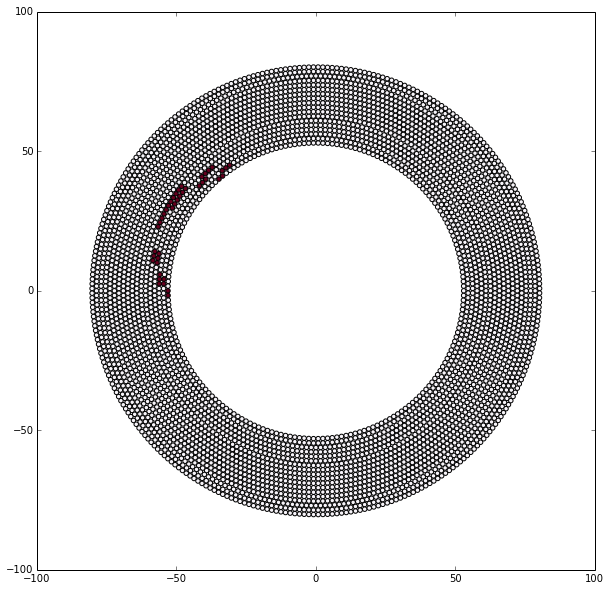

In [55]:
i = np.random.randint(len(pred))
print 'evt id=',i
draw_wire(evt_labels[n_train+i,:]==1,cmap='PuRd')
#draw_wire(pred[i,:]==1,cmap='PuRd')
#draw_wire(evt_labels[n_train+i,:]!=pred[i,:],cmap='PuRd')


In [64]:
from fit_circle_somehow import fit_circle as doit
def fit_circle(event_labels):
    Xs = wires._x
    Ys = wires._y
    (x,y,r) = doit(Xs[event_labels==1],Ys[event_labels==1])
    return x,y,r
x,y,r = fit_circle(pred[i,:])
x,y,r

(3.6052154585807097, -6.8302383128384898, 65.201749207493123)

In [88]:
from scipy import optimize
optimize.

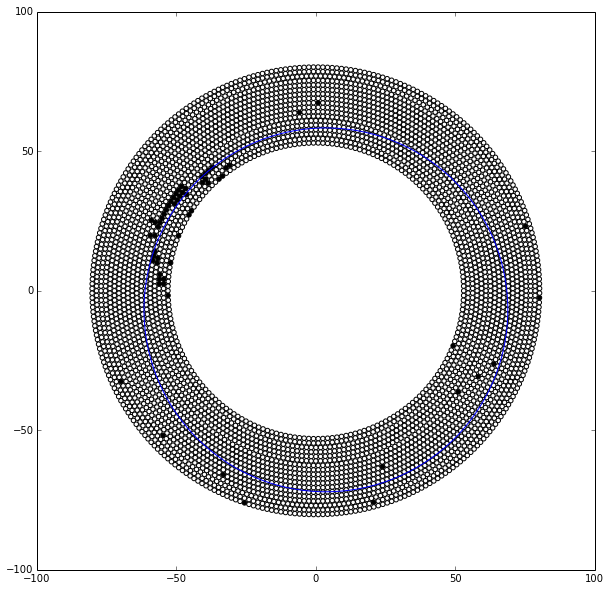

In [87]:
data_row = pred[i,:]==1
cmap = 'Greys'

fig = plt.figure(figsize=[10,10])
circle=plt.Circle((x,y),r,color='b',fill=False)

plt.scatter(wires._x,wires._y, c= data_row,cmap=cmap)
fig.gca().add_artist(circle)
plt.show()

In [334]:
from scipy import optimize
from numpy import *
x = None
y = None
l = None
scores=None
#weights = None

def f_2(c):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    xc,yc,r = c
    
    dr = absolute(sqrt(((x-xc)**2 + (y-yc)**2)) -r)
    #dr.sort()
    avg_s = np.average(dr[l==1])#,weights= weights[l==1])
    #avg_b = np.average(absolute(dr[l==2]),weights= weights[l==2])
    
    return  avg_s# - avg_b 

def doit(_x,_y,_l):
    wsize = 5
    global x,y,l,scores#,weights
    x=_x
    y=_y
    l=_l
    #weights = []
    scores = []
    for i in xrange(len(x)):
        dist_sq = ( (x-x[i])**2 + (y-y[i])**2)
        near_enough = dist_sq < wsize
        near_enough[i] = False #exclude self
        
        score = np.sum((1 - 2*(l[near_enough]==2))) #/dist_sq[near_enough]
        scores.append(score)
        
        #weights.append(1)#1./mean(dist_sq))
    
    #weights = np.array(weights)
    scores = np.array(scores)
    good = scores>1
    x = x[good]
    y = y[good]
    l = l[good]
    scores = scores[good]
    #weights = weights[good]
    

    center_estimate = mean(x), mean(y),30.
    print center_estimate
    
    center_2= optimize.fmin(f_2, center_estimate)#,maxiter=100000,maxfun=100000)
    
    xc_2, yc_2,R_2 = center_2
    return xc_2,yc_2,R_2
def fit_circle(event_labels):
    Xs = np.array(wires._x)
    Ys = np.array(wires._y)
    (xf,yf,rf) = doit(Xs[event_labels!=0],Ys[event_labels!=0],event_labels[event_labels!=0])
    return xf,yf,rf


(-11.131880789322354, -51.650296180023219, 30.0)


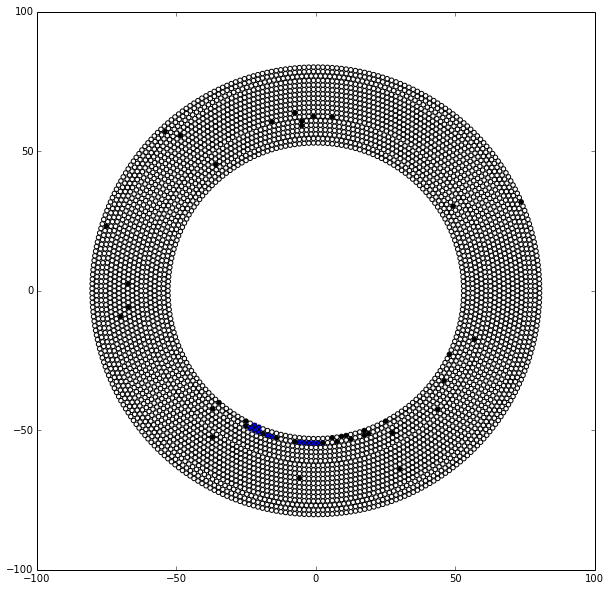

In [337]:
i = random.randint(len(pred)-1)
xc,yc,rc = fit_circle(pred[i,:])
xc,yc,rc

crcl = plt.Circle([xc,yc],radius=rc,color='b',fill=False)
fig = plt.figure(figsize=[10,10]) 
plt.gcf().gca().add_artist(crcl)
plt.scatter(wires._x,wires._y, c= pred[i,:]==1,cmap=cmap)
plt.scatter(x[l==1],y[l==1],marker='x')

plt.show()

In [ ]:
i = random.randint(len(pred)-1)
xc,yc,rc = fit_circle(pred[i,:])
xc,yc,rc

crcl = plt.Circle([xc,yc],radius=rc,color='b',fill=False)
fig = plt.figure(figsize=[10,10]) 
plt.gcf().gca().add_artist(crcl)
plt.scatter(wires._x,wires._y, c= pred[i,:]==1,cmap=cmap)
plt.scatter(x[l==1],y[l==1],marker='x')

plt.show()

In [330]:
pred = np.zeros(n_test*4482)
pred[Idts-n_train*4482] = 2 - (Yts_pred>0.35)
pred = group_by_event(pred)

630136320.64439607

In [ ]:
read=True
fname_tr = 'dumps/transformed final'
fname_ts = 'dumps/transformed stack train'
if not read:
    n_events = len(raw_train)/4482
    n_train = 500
    n_test = n_events-n_train
    #in_test = np.arange(4482*n_train)
    in_train = np.arange(4482*n_train,4482*n_events)

    Xtr,Ytr,Idtr = to_neigh_features(raw_train.irow(in_train),clf)
    joblib.dump([Xtr,Ytr,Idtr],fname_tr)

    
    Xts,Yts,Idts = to_neigh_features(raw_test.irow(in_train),clf)
    joblib.dump([Xts,Yts,Idts],fname_ts)
else:
    [Xtr,Ytr,Idtr] = joblib.load(fname_ts)
    [Xts,Yts,Idts] = joblib.load(fname_tr)
